# Init

In [108]:
!pip install shap

In [109]:
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [110]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [111]:
with open('pickle/dt_final.p', 'rb') as f:
    dt_final = pickle.load(f)

with open('pickle/svm_linear.p', 'rb') as f:
    svm_linear = pickle.load(f)

with open('pickle/knn_grid.p', 'rb') as f:
    knn_grid = pickle.load(f)

In [112]:
data = pd.read_csv('files/creditcard.csv')

In [113]:
X = data.drop('Class', axis=1)
y = data['Class']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [115]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [116]:
X_test.shape

(56962, 30)

# Voting

In [117]:
voting_clf = VotingClassifier(estimators=[
    ('decision_tree', dt_final),
    ('svm', svm_linear),
    ('knn', knn_grid)
], voting='soft')

In [118]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(max_depth=7,
                                                     random_state=42)),
                             ('svm',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=9))],
                 voting='soft')

In [119]:
y_pred_voting = voting_clf.predict(X_test)

In [120]:
print("Classification Report:\n", classification_report(y_test, y_pred_voting))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.76      0.84        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



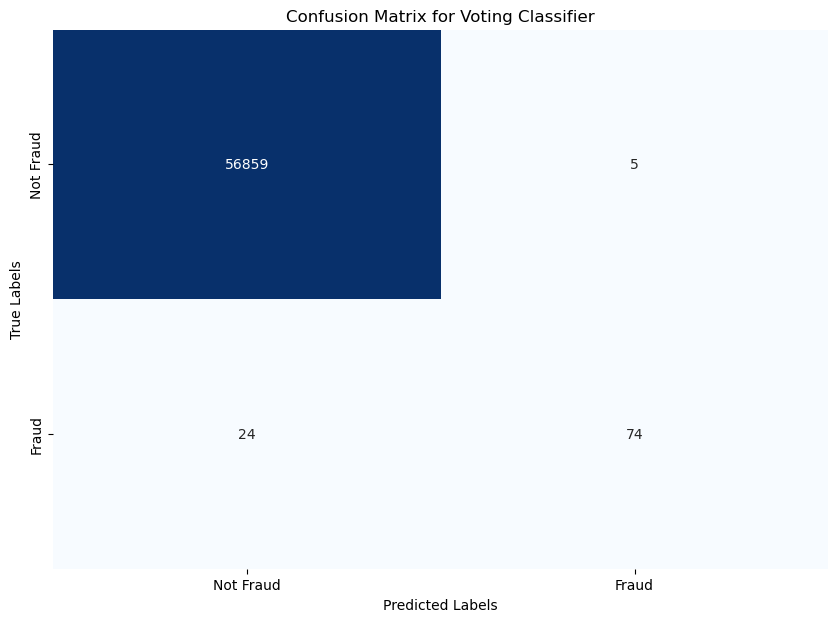

In [121]:
plot_confusion_matrix(y_test, y_pred_voting, title='Confusion Matrix for Voting Classifier')

# Random Forest

## Model

In [122]:
rf = RandomForestClassifier(max_depth=dt_final.get_depth(), random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=42)

In [123]:
y_pred_rf = rf.predict(X_test)

In [124]:
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.79      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962



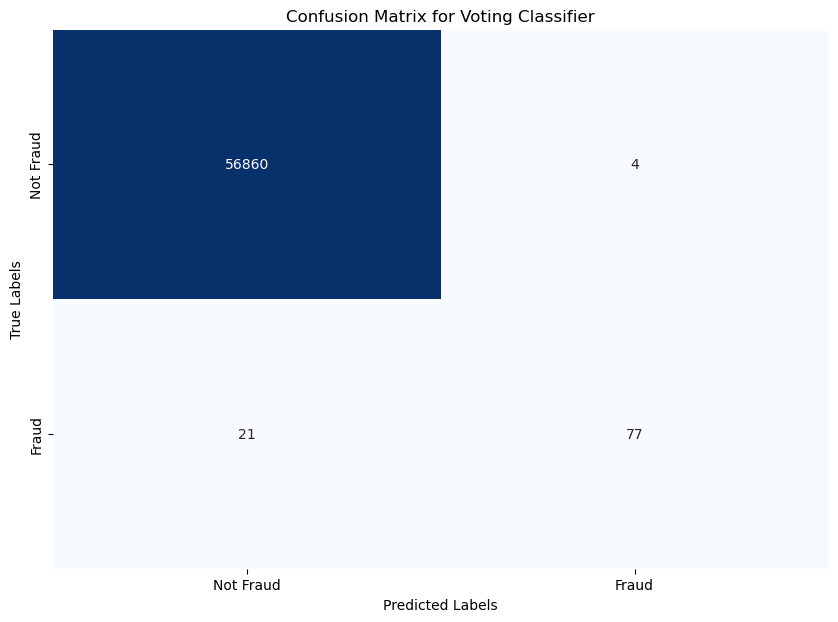

In [125]:
plot_confusion_matrix(y_test, y_pred_rf, title='Confusion Matrix for Voting Classifier')

## SHAP

In [126]:
explainer = shap.TreeExplainer(rf_model)

In [127]:
shap_values = explainer.shap_values(X_test)

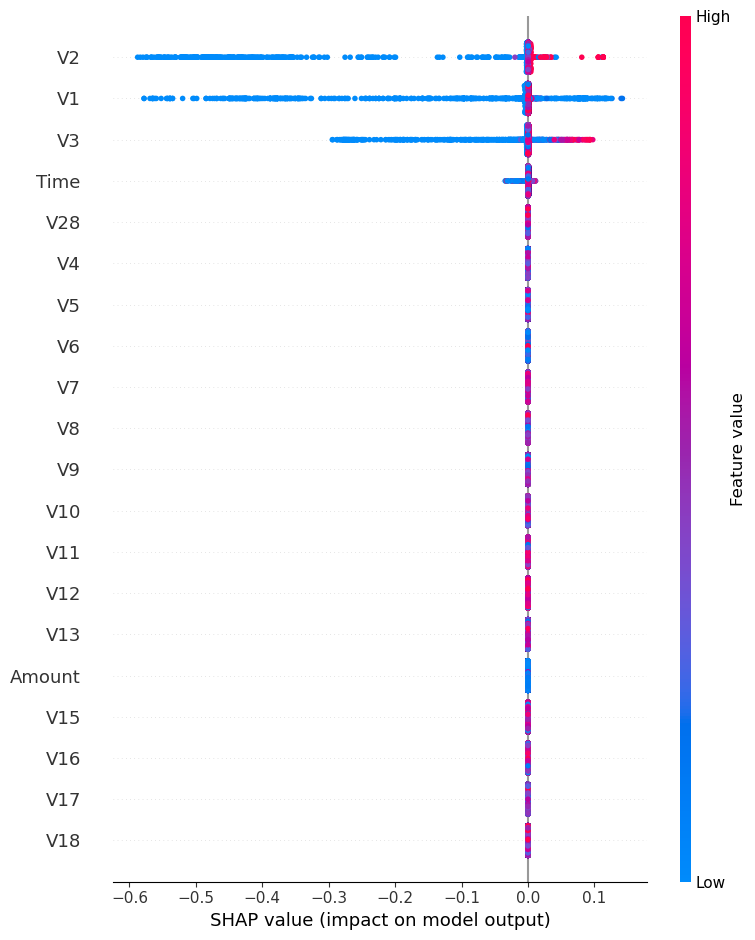

In [128]:
shap.summary_plot(
    shap_values[:,:, 0], 
    X_test
)

In [129]:
with open('pickle/voting_clf.p', 'wb') as file:
    pickle.dump(voting_clf, file)

In [130]:
with open('pickle/rf.p', 'wb') as file:
    pickle.dump(rf, file)